In [97]:
%matplotlib inline
import seaborn; seaborn.set_style('whitegrid')
import matplotlib.pyplot as plt
import torch

%load_ext watermark
%watermark -m -n -p torch,pomegranate
import numpy

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
torch      : 2.2.2
pomegranate: 1.1.2

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 24.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [98]:
from pomegranate.distributions import Categorical
# categories are A, C, G, T
# base distribution
d1 = Categorical([[0.25,0.25,0.25,0.25]])
# GC-heavy distribution
d2 = Categorical([[0.10, 0.40, 0.40, 0.10]])

In [99]:
d1.name='base'
d2.name='GC-heavy'

In [100]:
from pomegranate.hmm import DenseHMM

# initialize HMM which both states
model = DenseHMM()
model.add_distributions([d1, d2])

In [101]:
# equal initial likelihood for either state
model.add_edge(model.start, d1, 0.5)
model.add_edge(model.start, d2, 0.5)

# 10% chance of transitioning between states
model.add_edge(d1, d2, 0.1)
model.add_edge(d2, d1, 0.1)

# 90% chance of staying within a state
model.add_edge(d1, d1, 0.9)
model.add_edge(d2, d2, 0.9)

In [102]:
# create an array of nucleotides
sequence = 'CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC'
X = torch.tensor([[[['A', 'C', 'G', 'T'].index(char)] for char in sequence]])
X.shape

torch.Size([1, 51, 1])

In [103]:
y_hat = model.predict(X)

print(f"sequence: {sequence}")
print("hmm pred: {}".format(''.join([str(y.item()) for y in y_hat[0]])))

sequence: CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC
hmm pred: 000000000000000111111111111111100000000000000001111


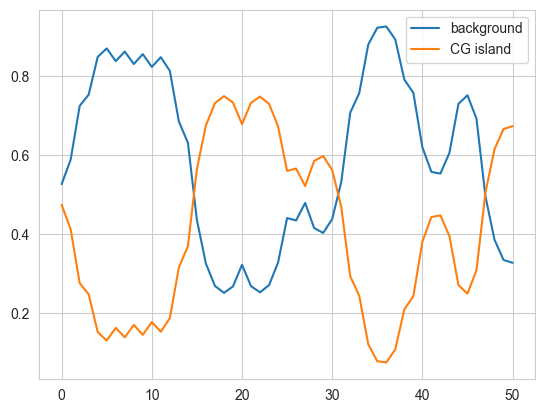

In [104]:
plt.plot(model.predict_proba(X)[0].numpy(), label=['background', 'CG island'])
plt.legend()
plt.show()

In [105]:
model.forward_backward(X)[0]

tensor([[[27.1324,  2.8387],
         [ 2.6396, 17.3886]]])

In [106]:
model.edges

tensor([[-0.1054, -2.3026],
        [-2.3026, -0.1054]])

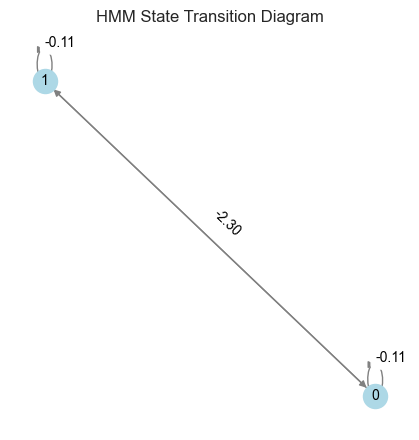

In [107]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for i, edge_tuple in enumerate(model.edges):
    for j, edge_weight in enumerate(edge_tuple):
        G.add_edge(str(i), str(j), weight=edge_weight)

plt.figure(figsize=(4,4))
pos = nx.spring_layout(G) 
label_pos = pos.copy()
for node in G.nodes():
    if G.has_edge(node, node):
        x,y = label_pos[node]
        label_pos[node]=x,y+0.01

labels = {edge: f"{d['weight']:.2f}" for edge, d in G.edges.items()}  # Edge labels
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', font_size=10)
nx.draw_networkx_edge_labels(
    G,
    label_pos,
    edge_labels=labels,
    label_pos=0.5,
    verticalalignment='baseline',
    horizontalalignment='left',
)

plt.title("HMM State Transition Diagram")
plt.show()

In [108]:
{edge: d['weight'] for edge, d in G.edges.items()}

{('0', '0'): tensor(-0.1054),
 ('0', '1'): tensor(-2.3026),
 ('1', '0'): tensor(-2.3026),
 ('1', '1'): tensor(-0.1054)}